In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from tqdm import tqdm
import sys
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1 Reading Data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Applied AI/case study 1/in-vehicle-coupon-recommendation.csv')
data.head()

destination  passanger weather  temperature  time  \
0  No Urgent Place      Alone   Sunny           55   2PM   
1  No Urgent Place  Friend(s)   Sunny           80  10AM   
2  No Urgent Place  Friend(s)   Sunny           80  10AM   
3  No Urgent Place  Friend(s)   Sunny           80   2PM   
4  No Urgent Place  Friend(s)   Sunny           80   2PM   

                  coupon expiration  gender age      maritalStatus  ...  \
0        Restaurant(<20)         1d  Female  21  Unmarried partner  ...   
1           Coffee House         2h  Female  21  Unmarried partner  ...   
2  Carry out & Take away         2h  Female  21  Unmarried partner  ...   
3           Coffee House         2h  Female  21  Unmarried partner  ...   
4           Coffee House         1d  Female  21  Unmarried partner  ...   

   CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50  \
0        never       NaN                  4~8              1~3   
1        never       NaN                  4~8              1~3   
2        never       NaN                  4~8              1~3   
3        never       NaN                  4~8              1~3   
4        never       NaN                  4~8              1~3   

  toCoupon_GEQ5min toCoupon_GEQ15min toCoupon_GEQ25min direction_same  \
0                1                 0                 0              0   
1                1                 0                 0              0   
2                1                 1                 0              0   
3                1                 1                 0              0   
4                1                 1                 0              0   

  direction_opp  Y  
0             1  1  
1             1  0  
2             1  1  
3             1  0  
4             1  0  

[5 rows x 26 columns]

In [ ]:
print("Number of data points:", data.shape[0])
print("Number of features:", data.shape[1])
print('-'*100)
print("The attributes of data :", data.columns.values)

Number of data points: 12684
Number of features: 26
----------------------------------------------------------------------------------------------------
The attributes of data : ['destination' 'passanger' 'weather' 'temperature' 'time' 'coupon'
 'expiration' 'gender' 'age' 'maritalStatus' 'has_children' 'education'
 'occupation' 'income' 'car' 'Bar' 'CoffeeHouse' 'CarryAway'
 'RestaurantLessThan20' 'Restaurant20To50' 'toCoupon_GEQ5min'
 'toCoupon_GEQ15min' 'toCoupon_GEQ25min' 'direction_same' 'direction_opp'
 'Y']


In [ ]:
data.info()
# data.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

## 1.2 Data Cleaning

In [ ]:
# Remove duplicates
duplicate = data[data.duplicated(keep = 'last')]
# duplicate.shape #(74, 26)
data = data.drop_duplicates()
data.shape

(12610, 26)

In [ ]:
# missing values
print('Is there any missing value present or not?',data.isnull().values.any())
missing_percentage = data.isnull().sum()*100/len(data)
missing_value_df = pd.DataFrame({'missing_count': data.isnull().sum(),'missing_percentage': missing_percentage})
missing_value_df[missing_value_df.missing_count != 0]

Is there any missing value present or not? True


missing_count  missing_percentage
car                           12502           99.143537
Bar                             107            0.848533
CoffeeHouse                     217            1.720856
CarryAway                       150            1.189532
RestaurantLessThan20            129            1.022998
Restaurant20To50                189            1.498810

* Feature 'car' has 99% of the missing value, drop this feature because even after predicting missing values, this feature has less importance, and it has less predictive power.

In [ ]:
data = data.drop(['car'], axis=1)

In [ ]:
# mode imputation for missing values
data['Bar'] = data['Bar'].fillna(data['Bar'].value_counts().index[0])
data['CoffeeHouse'] = data['CoffeeHouse'].fillna(data['CoffeeHouse'].value_counts().index[0])
data['CarryAway'] = data['CarryAway'].fillna(data['CarryAway'].value_counts().index[0])
data['RestaurantLessThan20'] = data['RestaurantLessThan20'].fillna(data['RestaurantLessThan20'].value_counts().index[0])
data['Restaurant20To50'] = data['Restaurant20To50'].fillna(data['Restaurant20To50'].value_counts().index[0])

In [ ]:
print('Is there any missing value present or not?',data.isnull().values.any())

Is there any missing value present or not? False


In [ ]:
data.cov() #covariance matrix 

temperature  has_children  toCoupon_GEQ5min  \
temperature         366.852199     -0.175502               0.0   
has_children         -0.175502      0.242711               0.0   
toCoupon_GEQ5min      0.000000      0.000000               0.0   
toCoupon_GEQ15min    -1.493656      0.019427               0.0   
toCoupon_GEQ25min    -1.393448     -0.001700               0.0   
direction_same        0.771641     -0.006554               0.0   
direction_opp        -0.771641      0.006554               0.0   
Y                     0.563590     -0.010997               0.0   

                   toCoupon_GEQ15min  toCoupon_GEQ25min  direction_same  \
temperature                -1.493656          -1.393448        0.771641   
has_children                0.019427          -0.001700       -0.006554   
toCoupon_GEQ5min            0.000000           0.000000        0.000000   
toCoupon_GEQ15min           0.246444           0.051076       -0.061664   
toCoupon_GEQ25min           0.051076           0.102567       -0.025009   
direction_same             -0.061664          -0.025009        0.169098   
direction_opp               0.061664           0.025009       -0.169098   
Y                          -0.020338          -0.017158        0.003042   

                   direction_opp         Y  
temperature            -0.771641  0.563590  
has_children            0.006554 -0.010997  
toCoupon_GEQ5min        0.000000  0.000000  
toCoupon_GEQ15min       0.061664 -0.020338  
toCoupon_GEQ25min       0.025009 -0.017158  
direction_same         -0.169098  0.003042  
direction_opp           0.169098 -0.003042  
Y                      -0.003042  0.245454

1. Feature ‘direction_same’ is perfectly correlated with ‘direction_opp’, both have the same variance.
2. ‘toCoupon_GEQ5min’ feature has 0 variances because it has the same value ‘1’ for all data points, which means all the restaurants/bars are at least more than five minutes away from the driver.

so, drop both 'direction_opp' and 'toCoupon_GEQ5min' features.

In [ ]:
data = data.drop(['direction_opp','toCoupon_GEQ5min'], axis=1)
data.shape

(12610, 23)

## 1.3 FE

In [ ]:
# FE -- to_Coupon is combination of two feature, toCoupon_GEQ15min and toCoupon_GEQ25min
to_Coupon = []
for i in tqdm(range(data.shape[0])):
    if (list(data['toCoupon_GEQ15min'])[i] == 0):
        to_Coupon.append(0)
    elif (list(data['toCoupon_GEQ15min'])[i] == 1)and(list(data['toCoupon_GEQ25min'])[i] == 0):
        to_Coupon.append(1)
    else:
        to_Coupon.append(2)
        
# print(len(to_Coupon)) #12610
data['to_Coupon'] = to_Coupon

100%|██████████| 12610/12610 [00:24<00:00, 521.95it/s]


## 1.4 Data Analysis

In [ ]:
print("After data cleaning and Feature Engineering,")
print("Number of data points:", data.shape[0])
print("Number of features:", data.shape[1])
print('-'*100)
print("The attributes of data :\n", data.columns.values)

After data cleaning and Feature Engineering,
Number of data points: 12610
Number of features: 24
----------------------------------------------------------------------------------------------------
The attributes of data :
 ['destination' 'passanger' 'weather' 'temperature' 'time' 'coupon'
 'expiration' 'gender' 'age' 'maritalStatus' 'has_children' 'education'
 'occupation' 'income' 'Bar' 'CoffeeHouse' 'CarryAway'
 'RestaurantLessThan20' 'Restaurant20To50' 'toCoupon_GEQ15min'
 'toCoupon_GEQ25min' 'direction_same' 'Y' 'to_Coupon']


In [ ]:
data.describe()
# data.describe(include='all')

temperature  has_children  toCoupon_GEQ15min  toCoupon_GEQ25min  \
count  12610.000000  12610.000000       12610.000000       12610.000000   
mean      63.267248      0.414512           0.559794           0.116019   
std       19.153386      0.492657           0.496432           0.320260   
min       30.000000      0.000000           0.000000           0.000000   
25%       55.000000      0.000000           0.000000           0.000000   
50%       80.000000      0.000000           1.000000           0.000000   
75%       80.000000      1.000000           1.000000           0.000000   
max       80.000000      1.000000           1.000000           1.000000   

       direction_same             Y     to_Coupon  
count    12610.000000  12610.000000  12610.000000  
mean         0.215543      0.567565      0.675813  
std          0.411215      0.495434      0.671687  
min          0.000000      0.000000      0.000000  
25%          0.000000      0.000000      0.000000  
50%          0.000000      1.000000      1.000000  
75%          0.000000      1.000000      1.000000  
max          1.000000      1.000000      2.000000

In [ ]:
Y_value_counts = data.groupby('Y').Y.count()
print('The number of users that are accepted the coupon is ',Y_value_counts[1],',',round(Y_value_counts[1]/data.shape[0]*100,3),'%')
print('The number of users that are rejected the coupon is ',Y_value_counts[0],',',round(Y_value_counts[0]/data.shape[0]*100,3),'%')

The number of users that are accepted the coupon is  7157 , 56.757 %
The number of users that are rejected the coupon is  5453 , 43.243 %


### 1.4.1 Univariate Analysis

In [ ]:
def univariate_analysis(column_name):
    df_EDA = pd.DataFrame(sorted(list(data[column_name].unique())),columns=[column_name])
    df_EDA['Total_Count'] = list(data.groupby(column_name).Y.count())
    df_EDA['Accepted'] = list(data[data.Y==1].groupby(column_name).Y.count())
    df_EDA['Rejected'] = list(data[data.Y==0].groupby(column_name).Y.count())
    df_EDA['%Accepted'] = round(df_EDA['Accepted']/df_EDA['Total_Count']*100,3)
    df_EDA['%Rejected'] = round(df_EDA['Rejected']/df_EDA['Total_Count']*100,3)
    df_EDA = df_EDA.sort_values(by='Total_Count', ascending=False)
    
    fig = plt.subplots(figsize =(8, 4))
    plt.barh(df_EDA[column_name],df_EDA['Total_Count'])
    plt.barh(df_EDA[column_name],df_EDA['Accepted'])
    plt.legend(labels=['Total','Accepted'])
    plt.xlabel('Counts')
    plt.title(column_name+' wise accepted coupons')
    plt.show()

    return df_EDA

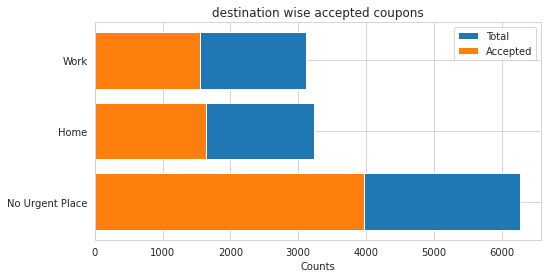

destination  Total_Count  Accepted  Rejected  %Accepted  %Rejected
1  No Urgent Place         6266      3969      2297     63.342     36.658
0             Home         3230      1635      1595     50.619     49.381
2             Work         3114      1553      1561     49.872     50.128

In [ ]:
univariate_analysis('destination')

__Observations:__
* Most of the users go to No Urgent Place.
* The users who have destination No Urgent Place are accepting more coupons than others.
* The users who have destination Home and Work have almost similar coupon acceptance ratios.

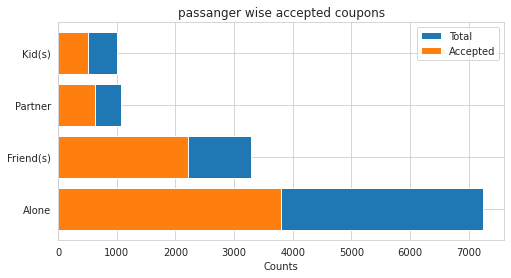

passanger  Total_Count  Accepted  Rejected  %Accepted  %Rejected
0      Alone         7248      3801      3447     52.442     47.558
1  Friend(s)         3292      2216      1076     67.315     32.685
3    Partner         1069       635       434     59.401     40.599
2     Kid(s)         1001       505       496     50.450     49.550

In [ ]:
univariate_analysis('passanger')

__Observations:__
* Most of the time users go out Alone.
* The users who go out with Friends are accepting more coupons than other co-passengers.
* The users who go out with Friends or Partner have more coupon acceptance ratios than Alone users.

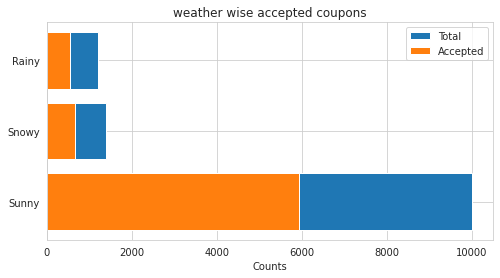

weather  Total_Count  Accepted  Rejected  %Accepted  %Rejected
2   Sunny        10011      5941      4070     59.345     40.655
1   Snowy         1397       659       738     47.173     52.827
0   Rainy         1202       557       645     46.339     53.661

In [ ]:
univariate_analysis('weather')

__Observations:__
* In Sunny weather, users go out more and accept more coupons than other wethers.

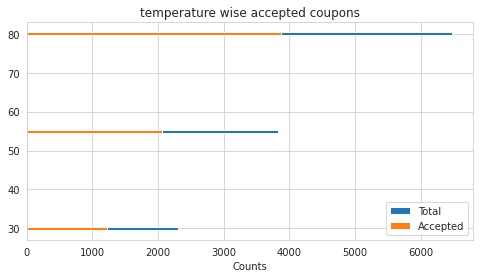

temperature  Total_Count  Accepted  Rejected  %Accepted  %Rejected
2           80         6475      3876      2599     59.861     40.139
1           55         3830      2056      1774     53.681     46.319
0           30         2305      1225      1080     53.145     46.855

In [ ]:
univariate_analysis('temperature')

__Observations:__
* Most of the time users go out when the temperature is 80 F.
* When the temperature is 80 F, user's coupon acceptance ratio is approx 59.86%.

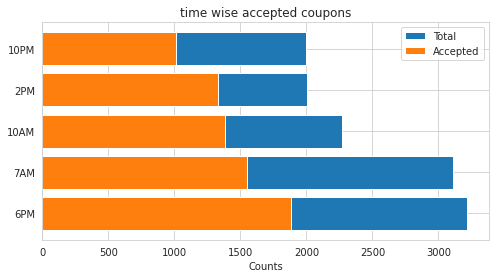

time  Total_Count  Accepted  Rejected  %Accepted  %Rejected
3   6PM         3220      1881      1339     58.416     41.584
4   7AM         3114      1553      1561     49.872     50.128
0  10AM         2271      1380       891     60.766     39.234
2   2PM         2006      1327       679     66.152     33.848
1  10PM         1999      1016       983     50.825     49.175

In [ ]:
univariate_analysis('time')

__Observations:__
* Most of the time users go out when the time is 6 PM and 7 AM.
* The users mostly accept coupons when the time is 2 PM and 10 AM.

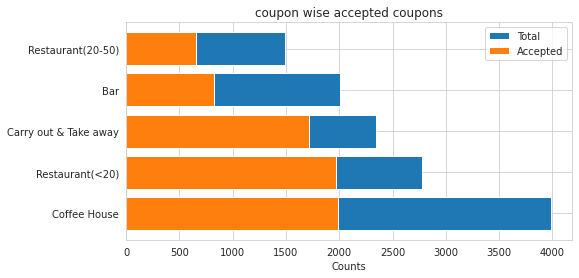

coupon  Total_Count  Accepted  Rejected  %Accepted  \
2           Coffee House         3989      1989      2000     49.862   
4        Restaurant(<20)         2779      1967       812     70.781   
1  Carry out & Take away         2344      1720       624     73.379   
0                    Bar         2010       824      1186     40.995   
3      Restaurant(20-50)         1488       657       831     44.153   

   %Rejected  
2     50.138  
4     29.219  
1     26.621  
0     59.005  
3     55.847

In [ ]:
univariate_analysis('coupon')

__Observations:__
* Maximum coupons offered are for Coffee House coupons.
* Maximum coupons accepted by users are Carry out & Take away and Restaurant(<20) coupons.
* Bar coupon has a very low acceptance ratio.

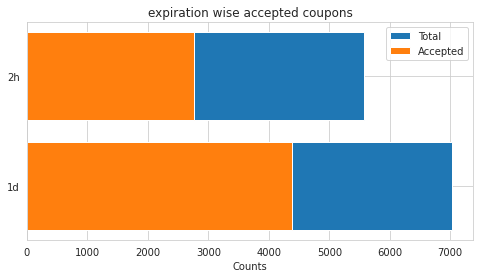

expiration  Total_Count  Accepted  Rejected  %Accepted  %Rejected
0         1d         7031      4390      2641     62.438     37.562
1         2h         5579      2767      2812     49.597     50.403

In [ ]:
univariate_analysis('expiration')

__Observations:__
* Maximum coupons are one-day expiration coupons
* Most of the users accept one-day expiration coupons.
* Two hours expiration coupons have a 50% acceptance ratio.

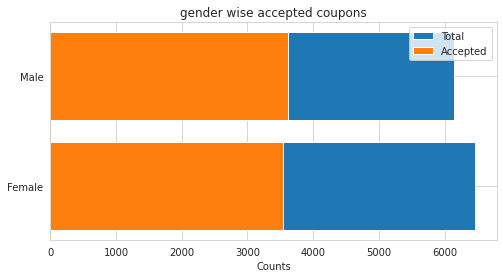

gender  Total_Count  Accepted  Rejected  %Accepted  %Rejected
0  Female         6469      3535      2934     54.645     45.355
1    Male         6141      3622      2519     58.981     41.019

In [ ]:
univariate_analysis('gender')

__Observations:__
* Male and Female both have almost similar coupon acceptance ratios.

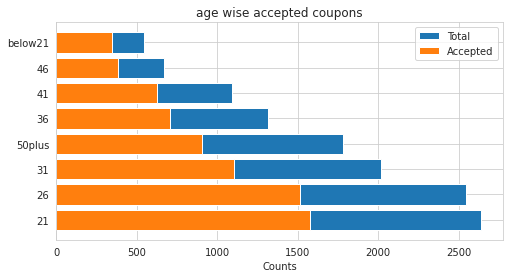

age  Total_Count  Accepted  Rejected  %Accepted  %Rejected
0       21         2642      1579      1063     59.765     40.235
1       26         2548      1517      1031     59.537     40.463
2       31         2019      1102       917     54.581     45.419
6   50plus         1781       903       878     50.702     49.298
3       36         1317       705       612     53.531     46.469
4       41         1089       623       466     57.208     42.792
5       46          670       384       286     57.313     42.687
7  below21          544       344       200     63.235     36.765

In [ ]:
univariate_analysis('age')

__Observations:__
* Most users in this data have ages between 21 to 26 years.
* The users whose age is below 21 years have the highest coupon acceptance ratio.
* The users whose age is above 50 years have the highest coupon rejection ratio.

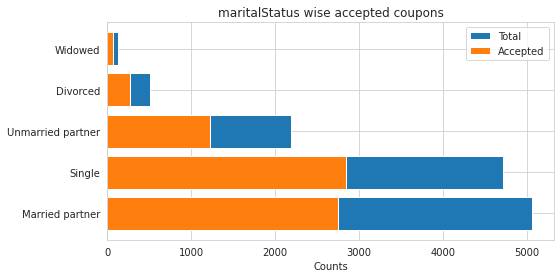

maritalStatus  Total_Count  Accepted  Rejected  %Accepted  %Rejected
1    Married partner         5068      2749      2319     54.242     45.758
2             Single         4716      2851      1865     60.454     39.546
3  Unmarried partner         2185      1226       959     56.110     43.890
0           Divorced          511       269       242     52.642     47.358
4            Widowed          130        62        68     47.692     52.308

In [ ]:
univariate_analysis('maritalStatus')

__Observations:__
* Most users in this data are Single or have Married partner.
* Single users accept more coupons than others.
* Users who have Unmarried partner accept more coupons than Married partner users.

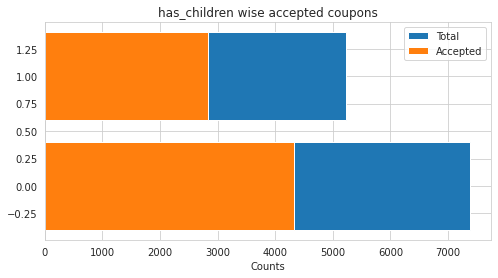

has_children  Total_Count  Accepted  Rejected  %Accepted  %Rejected
0             0         7383      4329      3054     58.635     41.365
1             1         5227      2828      2399     54.104     45.896

In [ ]:
univariate_analysis('has_children')

__Observations:__
* Most users has no children.
* Users who have no children have a slightly higher acceptance ratio than the users who have children.

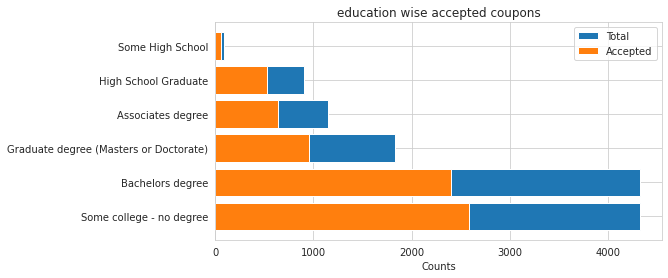

education  Total_Count  Accepted  Rejected  \
5                Some college - no degree         4325      2577      1748   
1                        Bachelors degree         4323      2395      1928   
2  Graduate degree (Masters or Doctorate)         1827       956       871   
0                       Associates degree         1148       634       514   
3                    High School Graduate          899       532       367   
4                        Some High School           88        63        25   

   %Accepted  %Rejected  
5     59.584     40.416  
1     55.401     44.599  
2     52.326     47.674  
0     55.226     44.774  
3     59.177     40.823  
4     71.591     28.409

In [ ]:
univariate_analysis('education')

__Observations:__
* Most users have at least a Bachelor's degree or Some college - no degree.
* In this data, very few users have only Some High School education, and those users have the highest coupon acceptance ratio.
* Users who have a Graduate degree (Masters or Doctorate) have the least coupon acceptance ratio. 

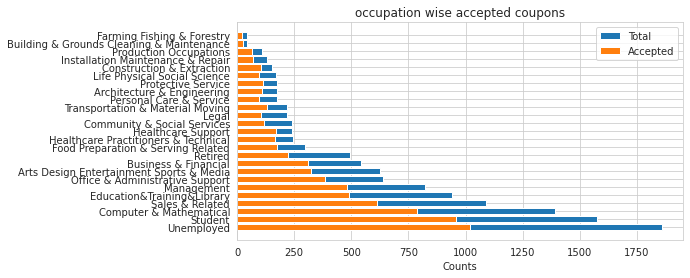

occupation  Total_Count  Accepted  \
24                                 Unemployed         1861      1019   
22                                    Student         1575       960   
5                     Computer & Mathematical         1390       787   
21                            Sales & Related         1088       612   
7                  Education&Training&Library          939       490   
15                                 Management          821       481   
16            Office & Administrative Support          638       383   
1    Arts Design Entertainment Sports & Media          627       324   
3                        Business & Financial          543       309   
20                                    Retired          493       225   
9          Food Preparation & Serving Related          298       174   
10       Healthcare Practitioners & Technical          244       165   
11                         Healthcare Support          242       169   
4                 Community & Social Services          239       116   
13                                      Legal          219       103   
23           Transportation & Material Moving          218       130   
17                    Personal Care & Service          175        96   
0                  Architecture & Engineering          175       111   
19                         Protective Service          174       112   
14               Life Physical Social Science          169        98   
6                   Construction & Extraction          154       106   
12          Installation Maintenance & Repair          133        71   
18                     Production Occupations          108        67   
2   Building & Grounds Cleaning & Maintenance           44        26   
8                  Farming Fishing & Forestry           43        23   

    Rejected  %Accepted  %Rejected  
24       842     54.756     45.244  
22       615     60.952     39.048  
5        603     56.619     43.381  
21       476     56.250     43.750  
7        449     52.183     47.817  
15       340     58.587     41.413  
16       255     60.031     39.969  
1        303     51.675     48.325  
3        234     56.906     43.094  
20       268     45.639     54.361  
9        124     58.389     41.611  
10        79     67.623     32.377  
11        73     69.835     30.165  
4        123     48.536     51.464  
13       116     47.032     52.968  
23        88     59.633     40.367  
17        79     54.857     45.143  
0         64     63.429     36.571  
19        62     64.368     35.632  
14        71     57.988     42.012  
6         48     68.831     31.169  
12        62     53.383     46.617  
18        41     62.037     37.963  
2         18     59.091     40.909  
8         20     53.488     46.512

In [ ]:
univariate_analysis('occupation')

__Observations:__
* Most users in this data are Unemployed and Student.
* Users who are students have more coupon acceptance ratio than Unemployed users. 
* Users who have occupation Healthcare Support and Construction & Extraction accept more coupons than others.

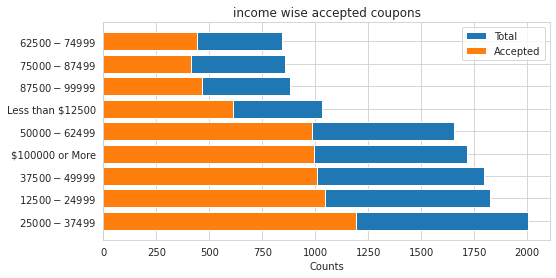

income  Total_Count  Accepted  Rejected  %Accepted  %Rejected
2   $25000 - $37499         2006      1190       816     59.322     40.678
1   $12500 - $24999         1825      1047       778     57.370     42.630
3   $37500 - $49999         1795      1010       785     56.267     43.733
0   $100000 or More         1717       992       725     57.775     42.225
4   $50000 - $62499         1655       984       671     59.456     40.544
8  Less than $12500         1034       612       422     59.188     40.812
7   $87500 - $99999          879       465       414     52.901     47.099
6   $75000 - $87499          856       414       442     48.364     51.636
5   $62500 - $74999          843       443       400     52.550     47.450

In [ ]:
univariate_analysis('income')

__Observations:__
* Most users in this data have income in between 12500\$ to 49999\$
* Users who have low income and high income accept more coupons than others.
* Users who have medium-range income are mostly rejecting the coupon.

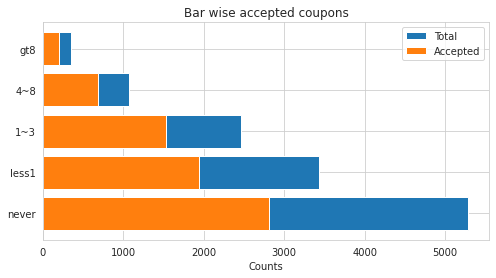

Bar  Total_Count  Accepted  Rejected  %Accepted  %Rejected
4  never         5285      2806      2479     53.094     46.906
3  less1         3438      1936      1502     56.312     43.688
0    1~3         2468      1533       935     62.115     37.885
1    4~8         1071       681       390     63.585     36.415
2    gt8          348       201       147     57.759     42.241

In [ ]:
univariate_analysis('Bar')

__Observations:__
* Most users in this data never visit a Bar.
* Very few users frequently (greater than 8 times) visit a Bar.
* Users who visited Bar 1to3 times or 4to8 times have a higher coupon acceptance ratio.

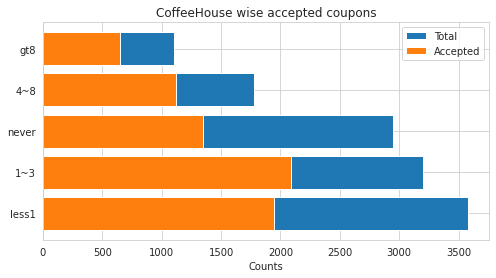

CoffeeHouse  Total_Count  Accepted  Rejected  %Accepted  %Rejected
3       less1         3579      1949      1630     54.457     45.543
0         1~3         3199      2089      1110     65.302     34.698
4       never         2946      1348      1598     45.757     54.243
1         4~8         1779      1125       654     63.238     36.762
2         gt8         1107       646       461     58.356     41.644

In [ ]:
univariate_analysis('CoffeeHouse')

__Observations:__
* Most users in this data have at least 1 time visited Coffee House.
* Users who visited Coffee House 1to3 times or 4to8 times have a higher coupon acceptance ratio.

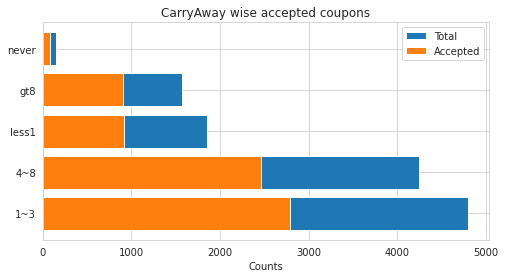

CarryAway  Total_Count  Accepted  Rejected  %Accepted  %Rejected
0       1~3         4795      2793      2002     58.248     41.752
1       4~8         4242      2462      1780     58.039     41.961
3     less1         1849       921       928     49.811     50.189
2       gt8         1572       900       672     57.252     42.748
4     never          152        81        71     53.289     46.711

In [ ]:
univariate_analysis('CarryAway')

__Observations:__
* Most users in this data have visited 1 to 8 times Carry Away services.
* Users who visited Carry Away services greater than 1 time have the highest coupon acceptance ratio is approx 58%.

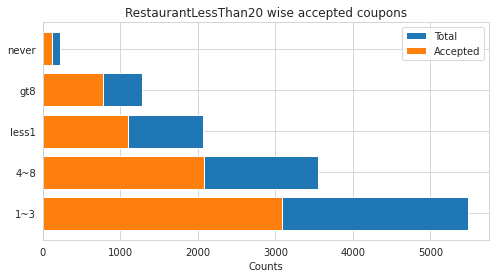

RestaurantLessThan20  Total_Count  Accepted  Rejected  %Accepted  %Rejected
0                  1~3         5485      3083      2402     56.208     43.792
1                  4~8         3553      2075      1478     58.401     41.599
3                less1         2071      1103       968     53.259     46.741
2                  gt8         1282       779       503     60.764     39.236
4                never          219       117       102     53.425     46.575

In [ ]:
univariate_analysis('RestaurantLessThan20')

__Observations:__
* Most users in this data have visited 1 to 8 times inexpensive Restaurant services.
* Users who visited inexpensive Restaurant greater than 1 time have the highest coupon acceptance ratio.

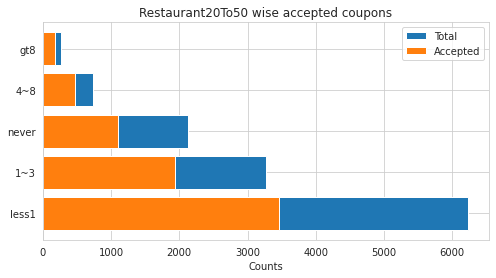

Restaurant20To50  Total_Count  Accepted  Rejected  %Accepted  %Rejected
3            less1         6230      3468      2762     55.666     44.334
0              1~3         3266      1942      1324     59.461     40.539
4            never         2122      1095      1027     51.602     48.398
1              4~8          728       477       251     65.522     34.478
2              gt8          264       175        89     66.288     33.712

In [ ]:
univariate_analysis('Restaurant20To50')

__Observations:__
* Restaurant20To50 is an expensive Restaurant where the average bill for one person is between 20\$ to 50\$.
* Most users visited an expensive Restaurant only one time.
* Users who visited an expensive Restaurant greater than 4 times have the highest coupon acceptance ratio.

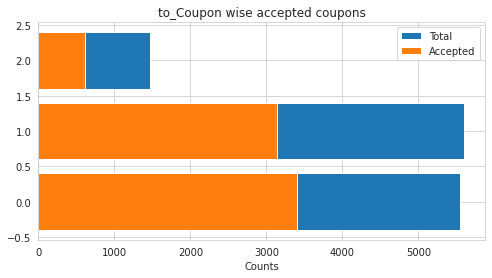

to_Coupon  Total_Count  Accepted  Rejected  %Accepted  %Rejected
1          1         5596      3136      2460     56.040     43.960
0          0         5551      3407      2144     61.376     38.624
2          2         1463       614       849     41.969     58.031

In [ ]:
univariate_analysis('to_Coupon')

__Observations:__
* 0: time to_coupon<15min, 1: 15min<=time to_coupon<25min, 2: time to_coupon>=25min
* Most coupons offered are nearby within 25 mins.
* Users generally accept the coupons which are less than 15 min distance.

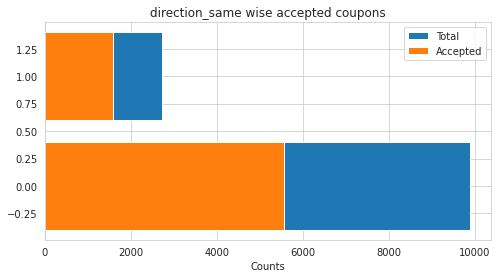

direction_same  Total_Count  Accepted  Rejected  %Accepted  %Rejected
0               0         9892      5576      4316     56.369     43.631
1               1         2718      1581      1137     58.168     41.832

In [ ]:
univariate_analysis('direction_same')

__Observations:__
* Most coupons offered are in the same direction as the user's destination.
* Same and Opposite both direction coupons have almost similar acceptance ratios.

### 1.4.2 Bivariate Analysis

In [ ]:
def bivariate_analysis(col1,col2,c1,c2,no_row):
    a = list(data[col1].unique())
    b = list(data[col2].unique())
    df = pd.DataFrame([(i, j) for i in a for j in b], columns=[col1,col2])
    Total_Count=[]; Accepted=[]; Rejected=[]
    for i in range(df.shape[0]):
        Total_Count.append((data[(c1==df[col1][i]) & (c2==df[col2][i])]).shape[0])
        Accepted.append((data[(c1==df[col1][i]) & (c2==df[col2][i]) & (data.Y==1)]).shape[0])
        Rejected.append((data[(c1==df[col1][i]) & (c2==df[col2][i]) & (data.Y==0)]).shape[0])
    df['Total_Count'] = Total_Count
    df['Accepted'] = Accepted
    df['Rejected'] = Rejected
    df['%Accepted'] = round(df['Accepted']/df['Total_Count']*100,3)
    df['%Rejected'] = round(df['Rejected']/df['Total_Count']*100,3)
    df = df.dropna()
    df = df.sort_values(by='%Accepted', ascending=False)
    d = pd.concat([df.head(no_row), df.tail(no_row)], axis=0)
    return d

__Q - What time do users go to Work, Home, or No Urgent Place, and with whom?__

Text(0.5, 1.0, 'destination vs time (count)')

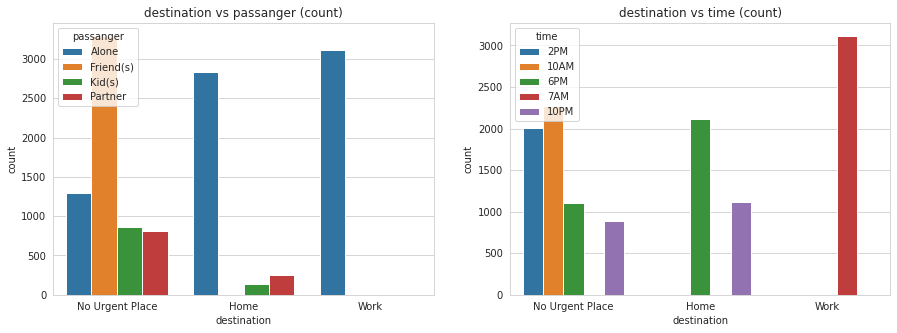

In [ ]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['destination'],hue=data['passanger'],ax=axes[0])
sns.countplot(data['destination'],hue=data['time'],ax=axes[1])
axes[0].set_title('destination vs passanger (count)'); axes[1].set_title('destination vs time (count)')

In [ ]:
bivariate_analysis('destination','time',data.destination,data.time,3)

destination  time  Total_Count  Accepted  Rejected  %Accepted  \
2   No Urgent Place   6PM         1102       730       372     66.243   
0   No Urgent Place   2PM         2006      1327       679     66.152   
1   No Urgent Place  10AM         2271      1380       891     60.766   
7              Home   6PM         2118      1151       967     54.344   
13             Work   7AM         3114      1553      1561     49.872   
9              Home  10PM         1112       484       628     43.525   

    %Rejected  
2      33.757  
0      33.848  
1      39.234  
7      45.656  
13     50.128  
9      56.475

In [ ]:
bivariate_analysis('passanger','time',data.passanger,data.time,3)

passanger  time  Total_Count  Accepted  Rejected  %Accepted  %Rejected
7   Friend(s)   6PM          592       448       144     75.676     24.324
0       Alone   2PM          361       265        96     73.407     26.593
17    Partner   6PM          309       216        93     69.903     30.097
12     Kid(s)   6PM          267       125       142     46.816     53.184
4       Alone  10PM          990       461       529     46.566     53.434
14     Kid(s)  10PM          167        43       124     25.749     74.251

__Observations:__
1. At 7 AM, only working users are going out Alone.
2. For Home, Users mostly go alone only at 6 PM or 10 PM.
3. With Friends, Users only go to No Urgent Place.
4. At 2 PM, Users only go to No Urgent Place.
5. For No Urgent Place, Users mostly go Alone at 2 PM and with Friends at 6 PM. 
6. Users who go with Friends at 6 PM have the highest acceptance ratio.
7. Users who go Alone at 2 PM also have the highest acceptance ratio.
8. Users who go with kids at 10 PM mostly reject the coupons.

__Q - Bivariate Analysis of Coupon type and its Expiration __

In [ ]:
bivariate_analysis('coupon','expiration',data.coupon,data.expiration,3)

coupon expiration  Total_Count  Accepted  Rejected  \
0        Restaurant(<20)         1d         1351      1123       228   
4  Carry out & Take away         1d         1411      1102       309   
5  Carry out & Take away         2h          933       618       315   
6                    Bar         1d         1553       640       913   
7                    Bar         2h          457       184       273   
9      Restaurant(20-50)         2h          535       160       375   

   %Accepted  %Rejected  
0     83.124     16.876  
4     78.101     21.899  
5     66.238     33.762  
6     41.211     58.789  
7     40.263     59.737  
9     29.907     70.093

__Observations:__
1. Most Users prefer to accept one-day expiration coupons than two hours expiration coupons.
2. Most Users accept the one-day expiration of Restaurant(<20) and Carry out & Take away coupons.
3. At any time, Most Users accept the two hours expiration of Carry out & Take away coupon.
4. Users mainly do not prefer to accept expensive Restaurant coupons with a low expiration time (2h).
5. Bar coupons have the least second preference in coupon acceptance.

__Q - At what time, which coupon acceptance ratio is high?__

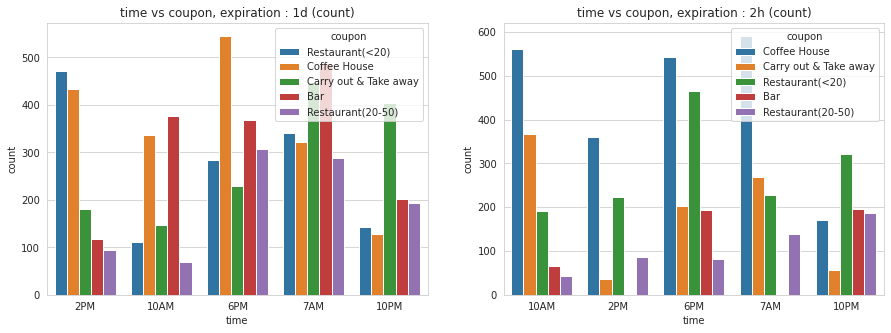

In [ ]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data[data.expiration == '1d']['time'],hue=data[data.expiration == '1d']['coupon'],ax=axes[0])
sns.countplot(data[data.expiration == '2h']['time'],hue=data[data.expiration == '2h']['coupon'],ax=axes[1])
axes[0].set_title('time vs coupon, expiration : 1d (count)'); axes[1].set_title('time vs coupon, expiration : 2h (count)');

In [ ]:
bivariate_analysis('coupon','time',data.coupon,data.time,4)

coupon  time  Total_Count  Accepted  Rejected  %Accepted  \
10  Carry out & Take away   2PM          218       189        29     86.697   
2         Restaurant(<20)   6PM          748       619       129     82.754   
12  Carry out & Take away   6PM          433       357        76     82.448   
0         Restaurant(<20)   2PM          696       567       129     81.466   
18                    Bar   7AM          487       178       309     36.550   
16                    Bar  10AM          443       160       283     36.117   
15                    Bar   2PM          118        40        78     33.898   
24      Restaurant(20-50)  10PM          380       125       255     32.895   

    %Rejected  
10     13.303  
2      17.246  
12     17.552  
0      18.534  
18     63.450  
16     63.883  
15     66.102  
24     67.105

__Observations:__
1. At 7 AM and 2 PM, the users will not get any request for a Bar coupon with a 2h expiration.
2. From 7 AM to 6 PM, Coffee House coupon ask is maximum.
3. At 10 PM, only Carry out & Take away(1d) and Restaurant(<20)(2h) coupon ask is highest.
4. At 2 PM and 6 PM, users mostly accept Restaurant(<20) and Carry out coupons with acceptance ratios above 80%.
5. At 2 PM, Users mostly accept Carry out & Take away coupons with an acceptance ratio approx 86%.
6. At 10 PM, generally, users do not accept expensive restaurant coupons.
7. Users mostly reject coupons for Bar at 7 AM, 10 AM, and 2 PM.

__Q - Bivariate Analysis of weather and temperature__

Text(0.5, 1.0, 'time vs weather (count)')

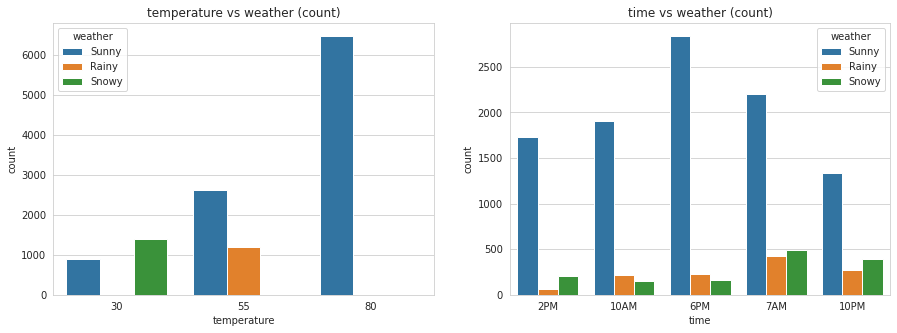

In [ ]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['temperature'],hue=data['weather'],ax=axes[0])
sns.countplot(data['time'],hue=data['weather'],ax=axes[1])
axes[0].set_title('temperature vs weather (count)'); axes[1].set_title('time vs weather (count)')

__Observations:__
1. At Snowy weather, Temperature is always 30 F.
2. At Rainy weather, Temperature is always 55 F.
3. At 80 F Temperature, weather is always Sunny.
4. At any time, most Users prefer to go out when the weather is Sunny.

__Q - Bivariate Analysis of weather and coupon type__

In [ ]:
bivariate_analysis('weather','coupon',data.weather,data.coupon,4)

weather                 coupon  Total_Count  Accepted  Rejected  %Accepted  \
0    Sunny        Restaurant(<20)         2237      1718       519     76.799   
2    Sunny  Carry out & Take away         1722      1312       410     76.190   
12   Snowy  Carry out & Take away          305       215        90     70.492   
7    Rainy  Carry out & Take away          317       193       124     60.883   
9    Rainy      Restaurant(20-50)           65        25        40     38.462   
8    Rainy                    Bar          427       155       272     36.300   
13   Snowy                    Bar          238        76       162     31.933   
14   Snowy      Restaurant(20-50)          177        54       123     30.508   

    %Rejected  
0      23.201  
2      23.810  
12     29.508  
7      39.117  
9      61.538  
8      63.700  
13     68.067  
14     69.492

__Observations:__
1. In Sunny weather, Restaurant(<20) and Carry out & Take away coupons have a maximum acceptance ratio approx 76%.
2. In Snowy and Rainy weather, Carry out & Take away coupon has the highest coupon acceptance ratio.
3. In Snowy and Rainy weather, Bar and expensive Restaurant has the lowest coupon acceptance ratio.

__Q - Analysis of passanger, maritalStatus and has_children features __

Text(0.5, 1.0, 'maritalStatus vs passanger (count)')

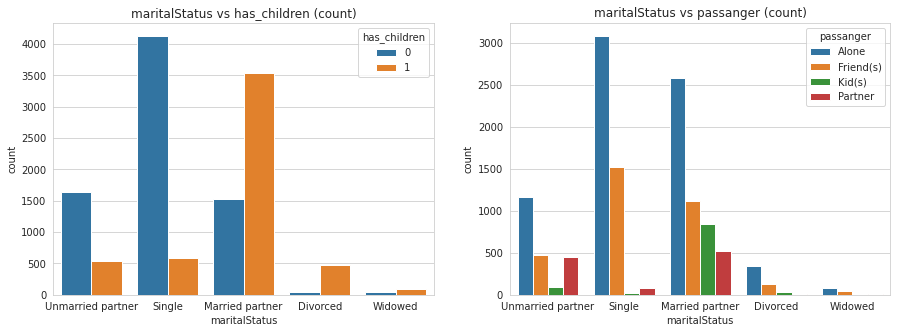

In [ ]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['maritalStatus'],hue=data['has_children'],ax=axes[0])
sns.countplot(data['maritalStatus'],hue=data['passanger'],ax=axes[1])
axes[0].set_title('maritalStatus vs has_children (count)'); axes[1].set_title('maritalStatus vs passanger (count)')

__Observations:__
1. The passenger feature depends on marital status and has_childrean features.
2. A single users always goes Alone or with Friends.
3. Mostly Married and Divorced users have children.
4. Generally, kids are going out with married Users mostly.
5. Widowed users have children but never travel with kid.
6. Approx 500 users lied about they are single because the single users should not have children.
7. The Single, unmarried, and married users who go with Friends have the highest coupon acceptance ratio.

__Q - Bivariate Analysis of gender and maritalStatus __

Text(0.5, 1.0, 'gender vs maritalStatus (Acceptance ratio)')

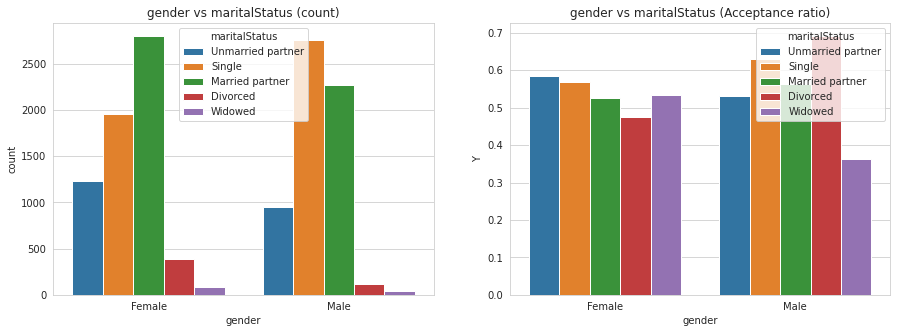

In [ ]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['gender'],hue=data['maritalStatus'],ax=axes[0])
sns.barplot(ax=axes[1], x="gender", y="Y", hue='maritalStatus', ci=None, data=data)
axes[0].set_title('gender vs maritalStatus (count)'); axes[1].set_title('gender vs maritalStatus (Acceptance ratio)')

__Observations:__
1. Most Male users are Single, and most Female users are Married.
2. More Female users are divorced and widowed than Male.
3. Single Male users have a coupon acceptance percentage is approx 63%.
4. Divorced Male users have a coupon acceptance ratio is approx 69%.

__Q - Analysis of passanger, maritalStatus and age features __

Text(0.5, 1.0, 'age vs passanger (count)')

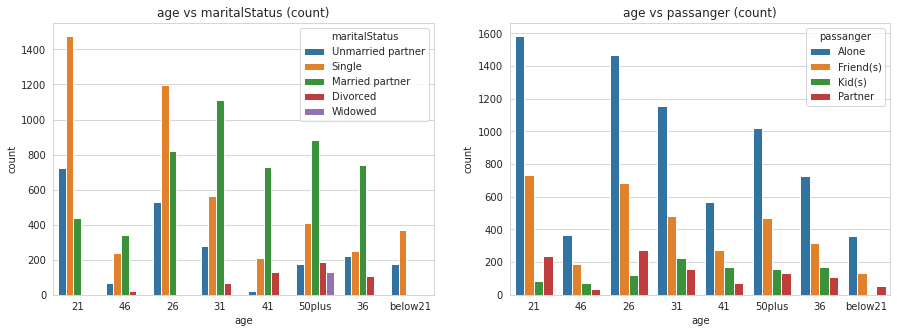

In [ ]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['age'],hue=data['maritalStatus'],ax=axes[0])
sns.countplot(data['age'],hue=data['passanger'],ax=axes[1])
axes[0].set_title('age vs maritalStatus (count)'); axes[1].set_title('age vs passanger (count)')

__Observations:__
1. below21, 21, 26 age users most of single or have an unmarried partner.
2. 31, 36, 41, 46, 50plus age users most of have Married partner.
3. All Widowed users have 50plus age.
4. Maximum Divorced users have 50plus age.
5. All Divorced users have an age above 31.
6. below21 age users never travel with kid.
7. Most Single, Married and Unmarried Users go out Alone or with Friends.

__Q - Which age group accept more coupon?__

Text(0.5, 1.0, 'age vs coupon (Acceptance ratio)')

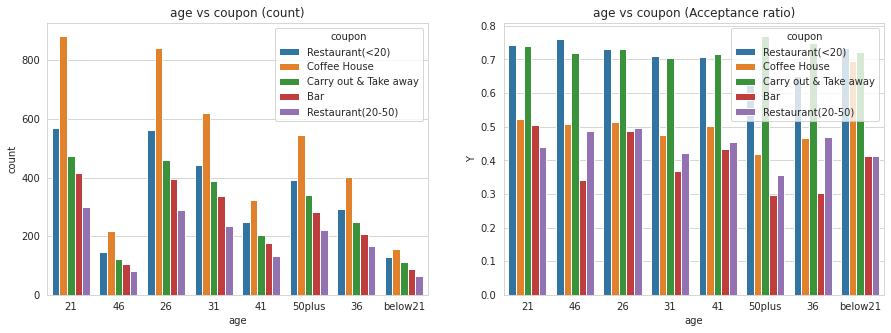

In [ ]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['age'],hue=data['coupon'],ax=axes[0])
sns.barplot(ax=axes[1], x="age", y="Y", hue='coupon', ci=None, data=data)
axes[0].set_title('age vs coupon (count)'); axes[1].set_title('age vs coupon (Acceptance ratio)')

__Observations:__
1. For Bar coupons, 21 and 26 age users accept the coupon more than others.
2. Mostly every age users accept Carry out & Take away and Restaurant(<20) coupons.
3. below21 age users have more acceptence for Coffee House coupons approx 70%.
4. Older age users have least acceptance for Bar Coupons.

__Q - Bivariate Analysis of Bar and coupon type __

Text(0.5, 1.0, 'Bar vs coupon (Acceptance ratio)')

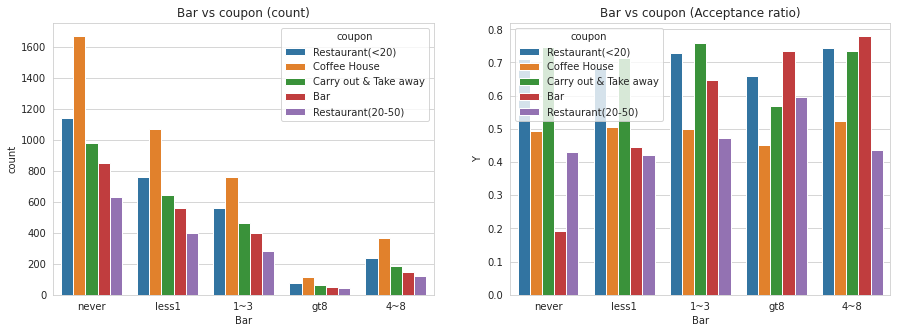

In [ ]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['Bar'],hue=data['coupon'],ax=axes[0])
sns.barplot(ax=axes[1], x="Bar", y="Y", hue='coupon', ci=None, data=data)
axes[0].set_title('Bar vs coupon (count)'); axes[1].set_title('Bar vs coupon (Acceptance ratio)')

In [ ]:
df = bivariate_analysis('Bar','coupon',data.Bar,data.coupon,13)
df[df.coupon == 'Bar']

Bar coupon  Total_Count  Accepted  Rejected  %Accepted  %Rejected
23    4~8    Bar          150       117        33     78.000     22.000
18    gt8    Bar           49        36        13     73.469     26.531
13    1~3    Bar          397       257       140     64.736     35.264
8   less1    Bar          563       250       313     44.405     55.595
3   never    Bar          851       164       687     19.271     80.729

__Observations:__
1. Users who have already been in Bar 4 to 8 time or more than 8 times has a maximum acceptance ratio for Bar coupons.
2. Users who have never been to Bar have the least acceptance ratio for Bar coupons.
3. Acceptance of Bar coupons depends on the Bar feature.

__Q - Bivariate Analysis of CoffeeHouse and coupon type __

Text(0.5, 1.0, 'CoffeeHouse vs coupon (Acceptance ratio)')

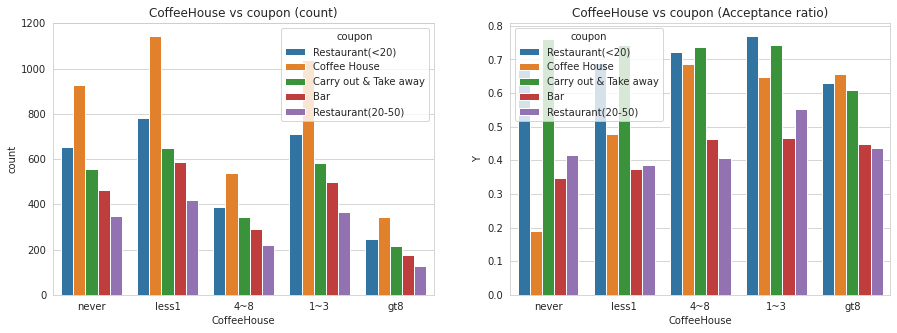

In [ ]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['CoffeeHouse'],hue=data['coupon'],ax=axes[0])
sns.barplot(ax=axes[1], x="CoffeeHouse", y="Y", hue='coupon', ci=None, data=data)
axes[0].set_title('CoffeeHouse vs coupon (count)'); axes[1].set_title('CoffeeHouse vs coupon (Acceptance ratio)')

In [ ]:
df = bivariate_analysis('CoffeeHouse','coupon',data.CoffeeHouse,data.coupon,13)
df[df.coupon == 'Coffee House']

CoffeeHouse        coupon  Total_Count  Accepted  Rejected  %Accepted  \
11         4~8  Coffee House          538       369       169     68.587   
21         gt8  Coffee House          342       225       117     65.789   
16         1~3  Coffee House         1038       672       366     64.740   
6        less1  Coffee House         1144       548       596     47.902   
1        never  Coffee House          927       175       752     18.878   

    %Rejected  
11     31.413  
21     34.211  
16     35.260  
6      52.098  
1      81.122

__Observations:__
1. Users who have already been in Coffee House 4 to 8 time or more than 8 times has a maximum acceptance ratio for Coffee House coupons.
2. Users who have never been to Coffee House have the least acceptance ratio for Coffee House coupons.
3. Acceptance of Coffee House coupons depends on the CoffeeHouse feature.

__Q - Bivariate Analysis of CarryAway and coupon type __

Text(0.5, 1.0, 'CarryAway vs coupon (Acceptance ratio)')

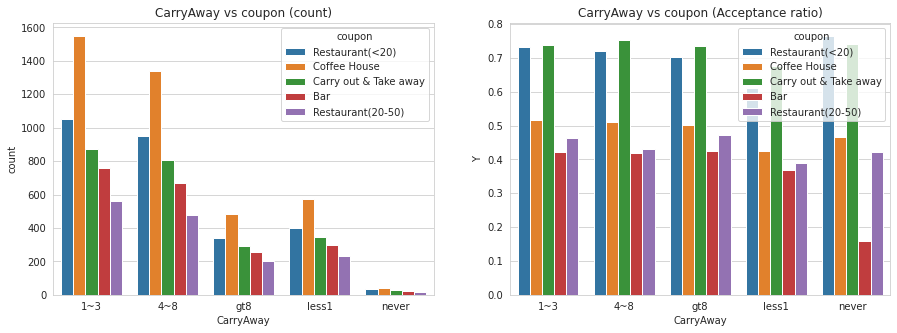

In [ ]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['CarryAway'],hue=data['coupon'],ax=axes[0])
sns.barplot(ax=axes[1], x="CarryAway", y="Y", hue='coupon', ci=None, data=data)
axes[0].set_title('CarryAway vs coupon (count)'); axes[1].set_title('CarryAway vs coupon (Acceptance ratio)')

In [ ]:
df = bivariate_analysis('CarryAway','coupon',data.CarryAway,data.coupon,13)
df[df.coupon == 'Carry out & Take away']

CarryAway                 coupon  Total_Count  Accepted  Rejected  \
7        4~8  Carry out & Take away          804       606       198   
22     never  Carry out & Take away           31        23         8   
2        1~3  Carry out & Take away          870       642       228   
12       gt8  Carry out & Take away          293       215        78   
17     less1  Carry out & Take away          346       234       112   

    %Accepted  %Rejected  
7      75.373     24.627  
22     74.194     25.806  
2      73.793     26.207  
12     73.379     26.621  
17     67.630     32.370

__Observations:__
1. Acceptance of Carry out & Take away coupons do not depend on the CarryAway feature.
2. Users who have never been to Carry out & Take away have 2nd highest acceptance ratio for Carry out coupons.
3. Every users have the good acceptance ratio for Carry out & Take away coupons

__Q - Bivariate Analysis of RestaurantLessThan20 and coupon type __

Text(0.5, 1.0, 'RestaurantLessThan20 vs coupon (Acceptance ratio)')

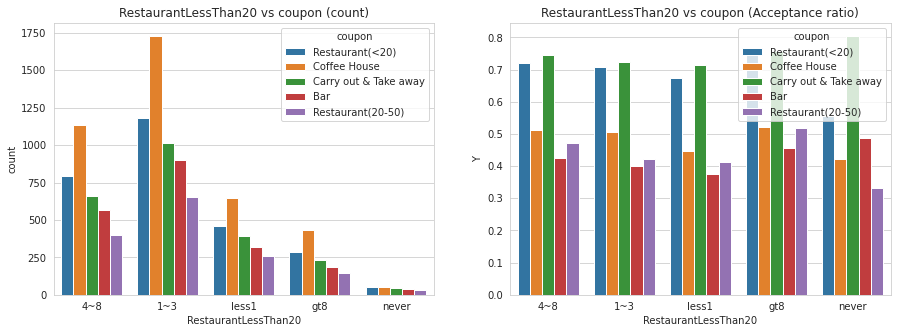

In [ ]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['RestaurantLessThan20'],hue=data['coupon'],ax=axes[0])
sns.barplot(ax=axes[1], x="RestaurantLessThan20", y="Y", hue='coupon', ci=None, data=data)
axes[0].set_title('RestaurantLessThan20 vs coupon (count)'); axes[1].set_title('RestaurantLessThan20 vs coupon (Acceptance ratio)')

In [ ]:
df = bivariate_analysis('RestaurantLessThan20','coupon',data.RestaurantLessThan20,data.coupon,13)
df[df.coupon == 'Restaurant(<20)']

RestaurantLessThan20           coupon  Total_Count  Accepted  Rejected  \
15                  gt8  Restaurant(<20)          288       219        69   
0                   4~8  Restaurant(<20)          795       572       223   
5                   1~3  Restaurant(<20)         1184       837       347   
10                less1  Restaurant(<20)          458       309       149   
20                never  Restaurant(<20)           54        30        24   

    %Accepted  %Rejected  
15     76.042     23.958  
0      71.950     28.050  
5      70.693     29.307  
10     67.467     32.533  
20     55.556     44.444

__Observations:__
1. Users who have already been in inexpensive Restaurant grater than 8 times have a maximum acceptance ratio for Restaurant(<20\$) coupons.
2. Users who have never been to inexpensive Restaurant have also 50% acceptance ratio for Restaurant(<20\$) coupons.
3. Acceptance of Restaurant(<20\$) coupons depends on the RestaurantLessThan20 feature.
4. Every users have the good acceptance ratio for Restaurant(<20\$) coupons

__Q - Bivariate Analysis of Restaurant20To50 and coupon type __

Text(0.5, 1.0, 'Restaurant20To50 vs coupon (Acceptance ratio)')

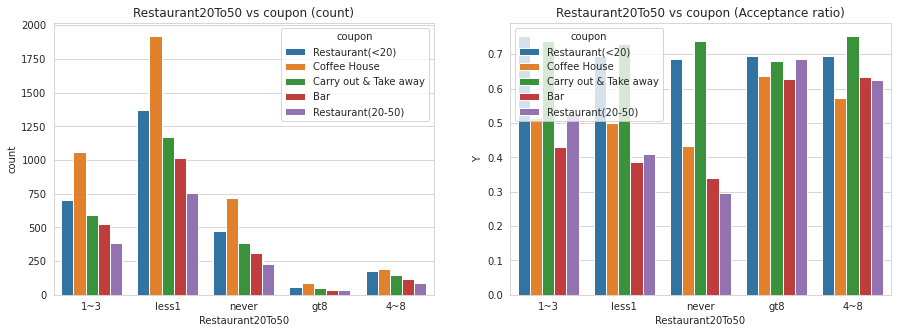

In [ ]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['Restaurant20To50'],hue=data['coupon'],ax=axes[0])
sns.barplot(ax=axes[1], x="Restaurant20To50", y="Y", hue='coupon', ci=None, data=data)
axes[0].set_title('Restaurant20To50 vs coupon (count)'); axes[1].set_title('Restaurant20To50 vs coupon (Acceptance ratio)')

In [ ]:
df = bivariate_analysis('Restaurant20To50','coupon',data.Restaurant20To50,data.coupon,13)
df[df.coupon == 'Restaurant(20-50)']

Restaurant20To50             coupon  Total_Count  Accepted  Rejected  \
19              gt8  Restaurant(20-50)           32        22        10   
24              4~8  Restaurant(20-50)           91        57        34   
4               1~3  Restaurant(20-50)          381       201       180   
9             less1  Restaurant(20-50)          754       309       445   
14            never  Restaurant(20-50)          230        68       162   

    %Accepted  %Rejected  
19     68.750     31.250  
24     62.637     37.363  
4      52.756     47.244  
9      40.981     59.019  
14     29.565     70.435

__Observations:__
1. Users who have already been in expensive Restaurant grater than 8 times have the highest acceptance ratio for Restaurant(20-50) coupons.
2. Users who have never been to expensive Restaurant have the least acceptance ratio for Restaurant(20-50) coupons.
3. Acceptance of Restaurant(20-50) coupons depends on the Restaurant20To50 feature.

__Q - Bivariate Analysis of to_Coupon and coupon type __

Text(0.5, 1.0, 'to_Coupon vs coupon (Acceptance ratio)')

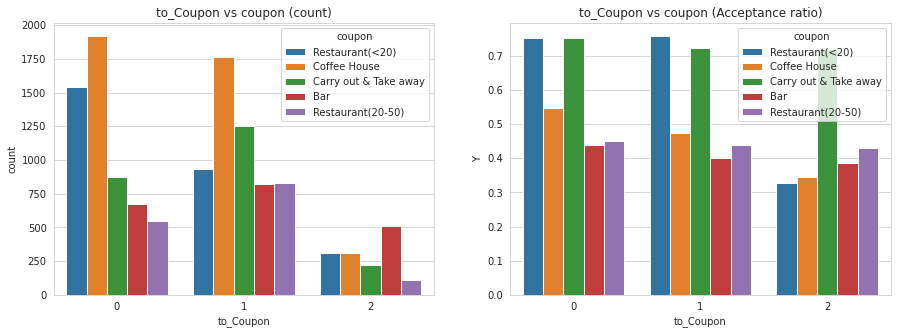

In [ ]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['to_Coupon'],hue=data['coupon'],ax=axes[0])
sns.barplot(ax=axes[1], x="to_Coupon", y="Y", hue='coupon', ci=None, data=data)
axes[0].set_title('to_Coupon vs coupon (count)'); axes[1].set_title('to_Coupon vs coupon (Acceptance ratio)')

In [ ]:
bivariate_analysis('to_Coupon','coupon',data.to_Coupon,data.coupon,4)

to_Coupon                 coupon  Total_Count  Accepted  Rejected  \
5           1        Restaurant(<20)          934       708       226   
0           0        Restaurant(<20)         1538      1158       380   
2           0  Carry out & Take away          872       656       216   
7           1  Carry out & Take away         1250       904       346   
8           1                    Bar          823       329       494   
13          2                    Bar          510       197       313   
11          2           Coffee House          310       107       203   
10          2        Restaurant(<20)          307       101       206   

    %Accepted  %Rejected  
5      75.803     24.197  
0      75.293     24.707  
2      75.229     24.771  
7      72.320     27.680  
8      39.976     60.024  
13     38.627     61.373  
11     34.516     65.484  
10     32.899     67.101

__Observations:__
1. 0: time to_coupon<15min, 1: 15min<=time to_coupon<25min, 2: time to_coupon>=25min
2. Very few coupons are offered to users which are far away more than 25 mins.
3. Coupons that have a distance greater than 25 mins have a maximum acceptance ratio for only Carry out & Take away coupons. 
4. Other than Carry out & Take away coupons have least acceptance ratio for coupons that have distance >=25min.
5. For <15min and >=15min & <25min coupons have almost similar acceptance ratio for every type of coupons.

__Q - Bivariate Analysis of direction_same and coupon type __

Text(0.5, 1.0, 'direction_same vs coupon (Acceptance ratio)')

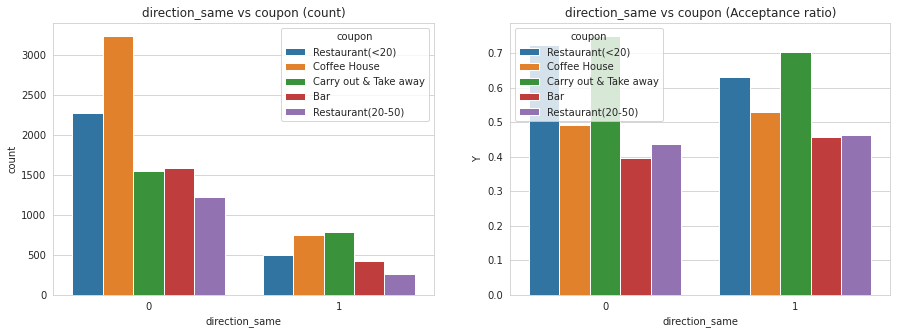

In [ ]:
fig,axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(data['direction_same'],hue=data['coupon'],ax=axes[0])
sns.barplot(ax=axes[1], x="direction_same", y="Y", hue='coupon', ci=None, data=data)
axes[0].set_title('direction_same vs coupon (count)'); axes[1].set_title('direction_same vs coupon (Acceptance ratio)')

__Observations:__
1. 0: direction_same, 1: direction_opposite
2. Very few opposite-direction coupons are offered to users.
3. Same and Opposite direction coupons have almost similar acceptance ratios for every coupon type.

### 1.4.3 Multivariate Analysis

In [ ]:
# https://plotly.com/python/splom/
import plotly.graph_objects as go

fig = go.Figure(data=go.Splom(
                dimensions=[dict(label='destination', values=data['destination']),
                dict(label='passanger', values=data['passanger']),
                dict(label='weather', values=data['weather']),
                dict(label='temperature', values=data['temperature']),
                dict(label='time', values=data['time']),
                dict(label='coupon', values=data['coupon']),
                dict(label='expiration', values=data['expiration']),
                dict(label='gender', values=data['gender']),
                dict(label='age', values=data['age']),
                dict(label='maritalStatus', values=data['maritalStatus']),
                dict(label='has_children', values=data['has_children']),
                dict(label='education', values=data['education']),
                dict(label='income', values=data['income']),
                dict(label='Bar', values=data['Bar']),
                dict(label='CoffeeHouse', values=data['CoffeeHouse']),
                dict(label='CarryAway', values=data['CarryAway']),
                dict(label='RestaurantLessThan20', values=data['RestaurantLessThan20']),
                dict(label='Restaurant20To50', values=data['Restaurant20To50']),
                dict(label='to_Coupon', values=data['to_Coupon']),
                dict(label='direction_same', values=data['direction_same']),
                dict(label='Y', values=data['Y'])],
                diagonal_visible=False, # remove plots on diagonal
                text=data['Y'],
                marker=dict(color=data['Y'].astype('category').cat.codes,
                            colorscale='Bluered',
                            showscale=True, # colors encode categorical variables
                            line_color='white', line_width=0.5),
                ))
fig.update_layout(
    title='in-vehicle-coupon-recommendation Data set',
    width=1800,
    height=1800,
)
fig.show()

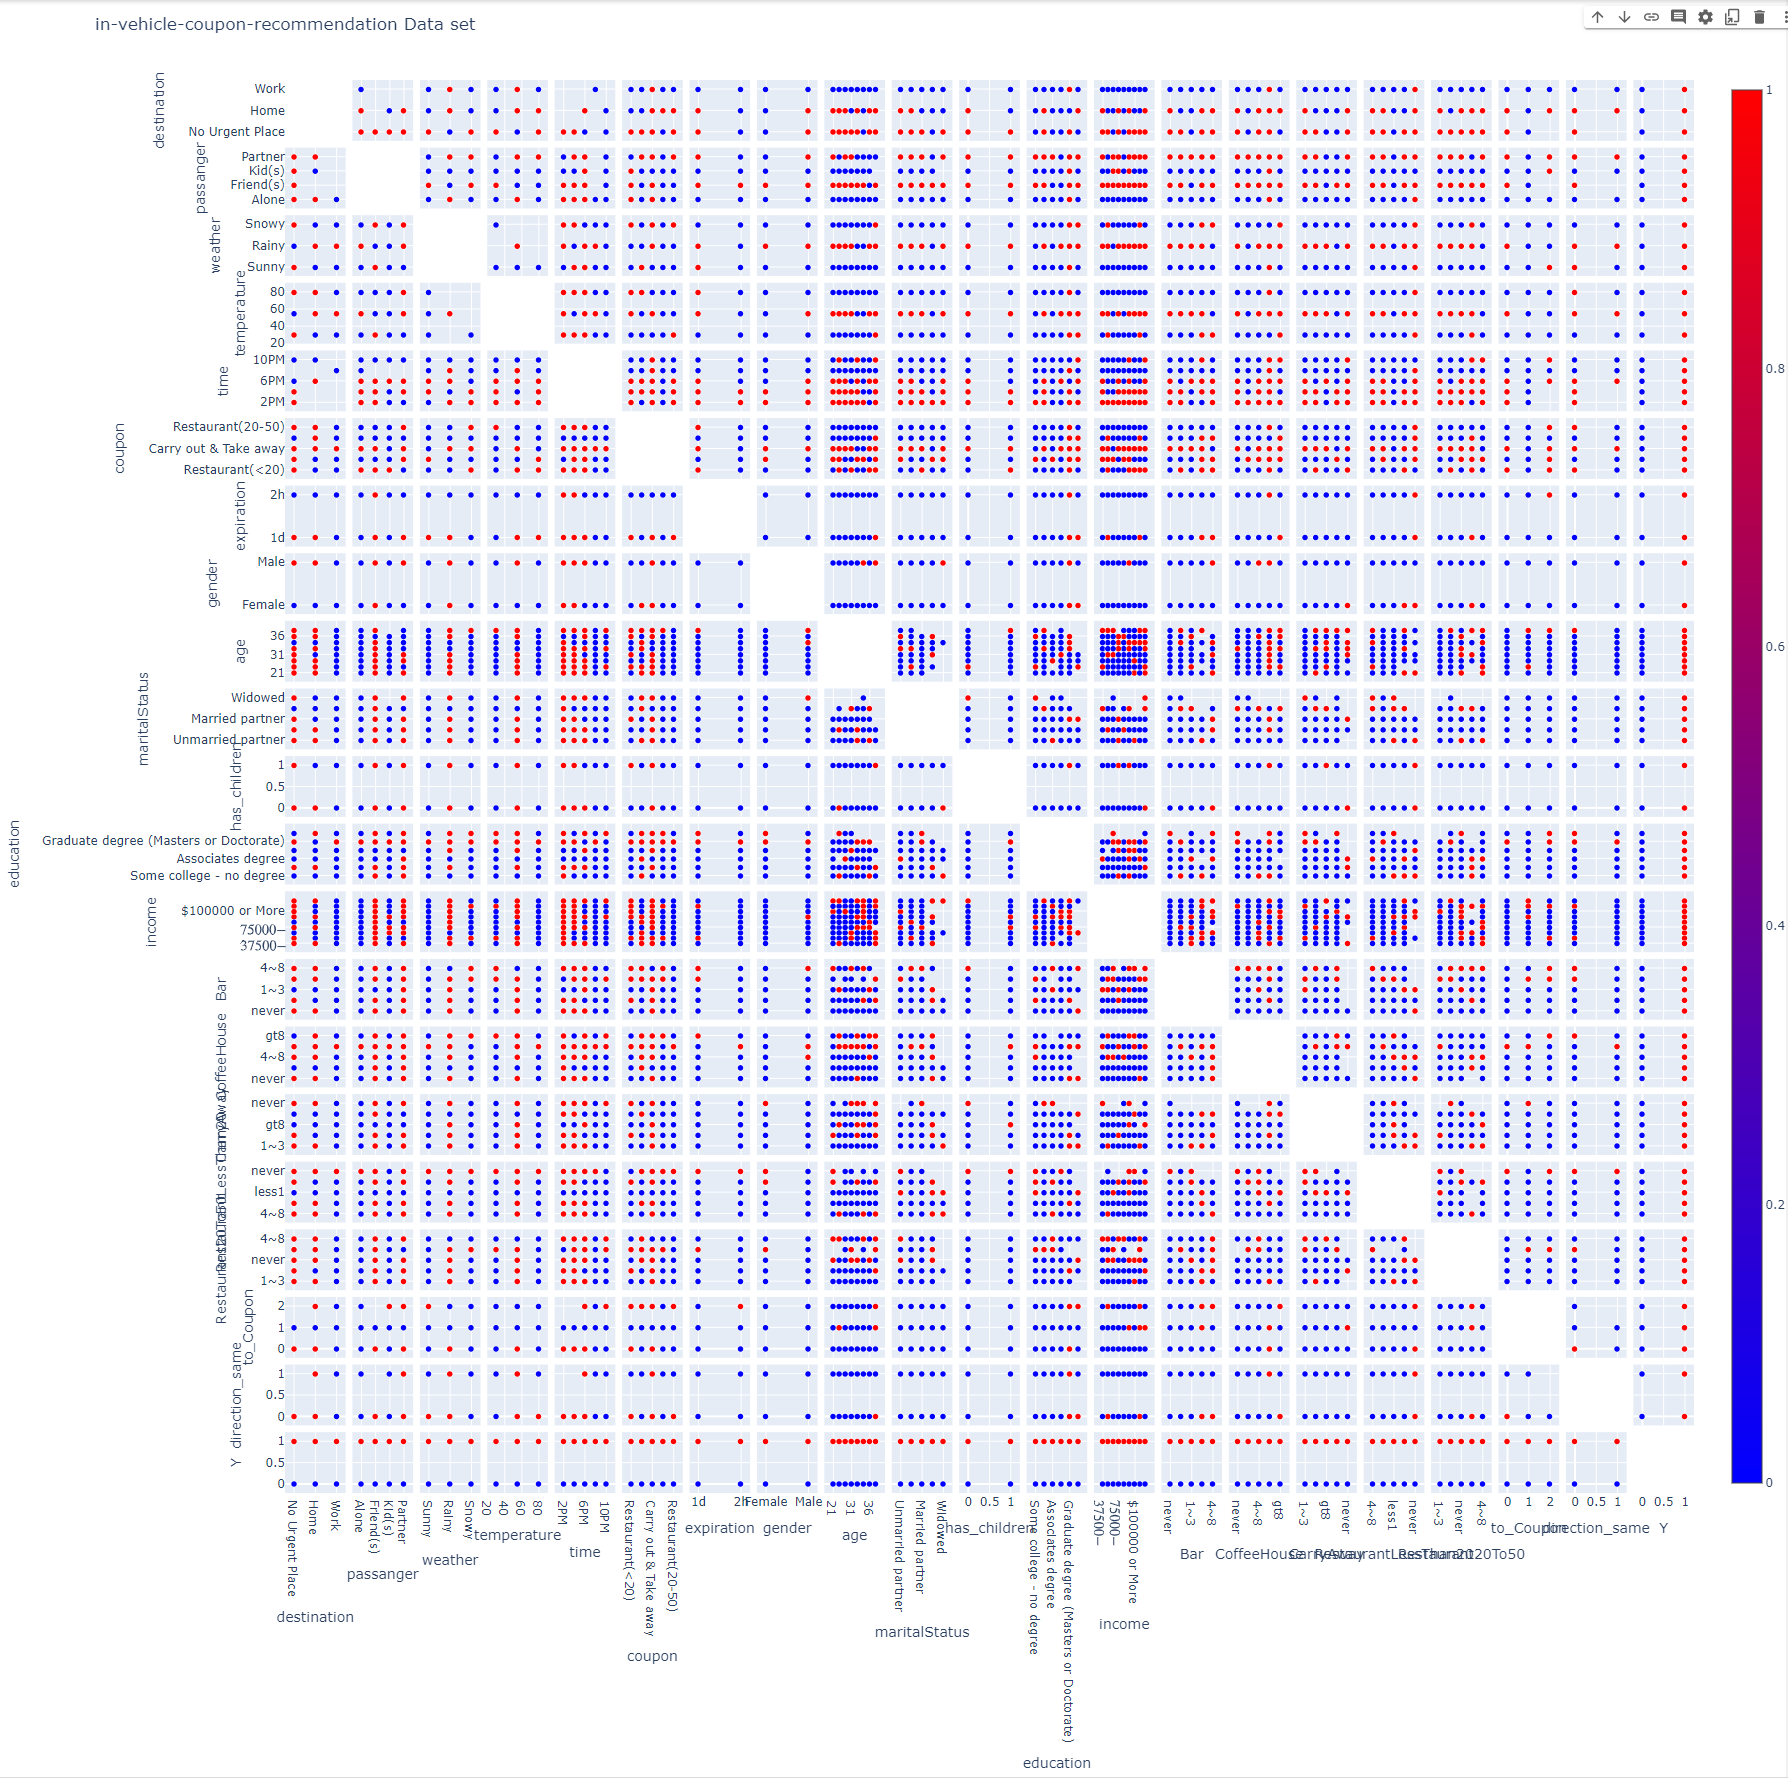

Link: https://drive.google.com/file/d/1mBP8o1Oc-aACXhxvQBmd831ombzIMfQN/view?usp=sharing

All the features are categorical so very hard to read the scatter plot while performing multivariate analysis due to overlapping.

__Observations:__
* Users with Friends only go to No Urgent Place.
* Users who go to Work always go Alone at 7 AM.
* At 10 AM and 2 PM, Users only go to No Urgent Place.
* When the weather is Rainy, the Temperature is 55 F, and when the weather is Snowy, the Temperature is 30 F.
* Users who have age below 21 never travel with a kid.
* Users who travel with kids never be Widowed.
* Users who go to No Urgent Place are never asked for coupons more than 25 min away and in opposite direction.
* Only Users whose age is 50 plus are Widowed.
* More than 31 age users generally get Divorced.
* Only 26, 31, 46 age users have Some High School education.
* Users whose age is below 21 have only Some college - no degree or Bachelors degree or High School Graduate educations.
* Users who are Widowed have very low income up to 25000\$.
* Users who are Divorced have average income up to 62500\$.
* Users who have Some High School education have very low income up to 25000\$.
* Widowed Users generally very few times visit Bar or Carry out & Take away or Restaurant or Coffee House.

__Multivariate Analysis using Pivot Table__

Text(0.5, 1.0, 'Pivot Table of User attributes with Target attribute')

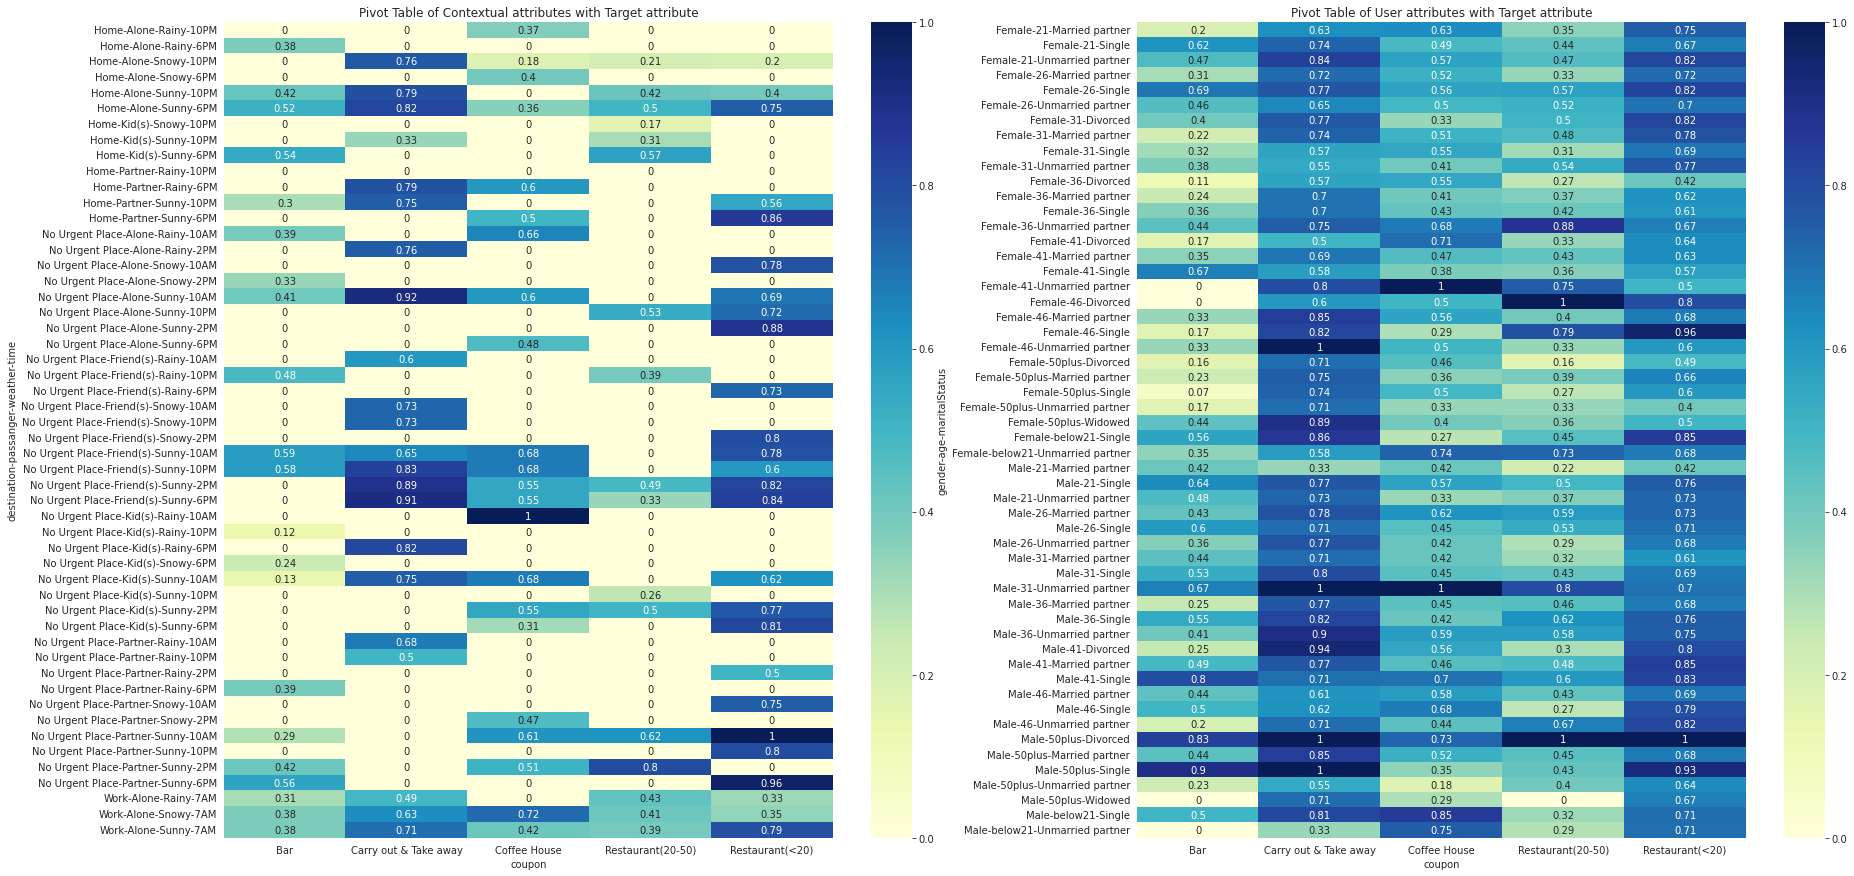

In [ ]:
result1 = pd.pivot_table(data=data, index=['destination','passanger','weather','time'], columns='coupon',values='Y',aggfunc=np.mean, fill_value=0)
result2 = pd.pivot_table(data=data, index=['gender','age','maritalStatus'], columns='coupon',values='Y',aggfunc=np.mean, fill_value=0)

fig,axes = plt.subplots(1, 2, figsize=(30, 15))
sns.heatmap(result1, annot=True, cmap = 'YlGnBu', ax=axes[0])
sns.heatmap(result2, annot=True, cmap = 'YlGnBu', ax=axes[1])
axes[0].set_title('Pivot Table of Contextual attributes with Target attribute'); axes[1].set_title('Pivot Table of User attributes with Target attribute')

Link: https://drive.google.com/file/d/1HjNC5fiHXwE-PgyCzkiokha1acpoqbwi/view?usp=sharing

__Observations:__
* From all 5 coupon types, the maximum coupons acceptance rate is for Carry out & Take away and inexpensive Restaurant coupons.
* Most users go out in Sunny Whether have a high coupon acceptance ratio.
* Most users accept the coupons at 6 PM, 10 AM, and 2 PM.
* Users who are going to No Urgent Place Alone or with Friends accept more coupons.

Text(0.5, 1.0, 'Pivot Table of education and income with Target attribute')

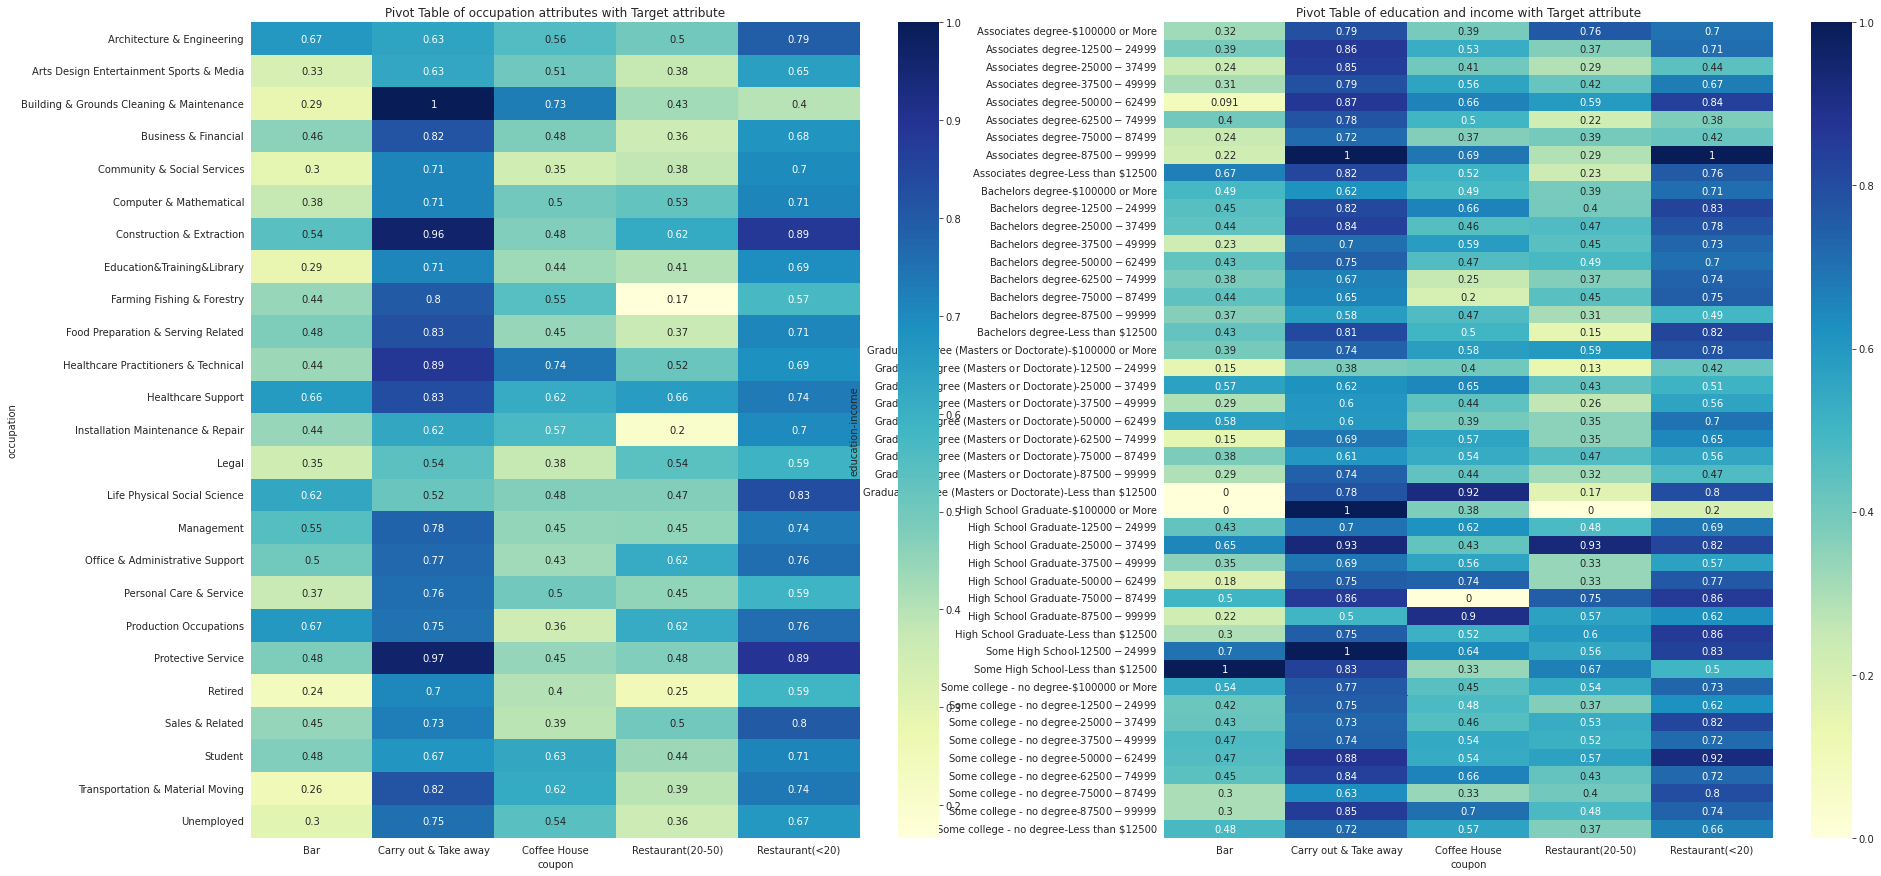

In [ ]:
result1 = pd.pivot_table(data=data, index=['occupation'], columns='coupon',values='Y',aggfunc=np.mean, fill_value=0)
result2 = pd.pivot_table(data=data, index=['education','income'], columns='coupon',values='Y',aggfunc=np.mean, fill_value=0)

fig,axes = plt.subplots(1, 2, figsize=(30, 15))
sns.heatmap(result1, annot=True, cmap = 'YlGnBu', ax=axes[0])
sns.heatmap(result2, annot=True, cmap = 'YlGnBu', ax=axes[1])
axes[0].set_title('Pivot Table of occupation attributes with Target attribute'); axes[1].set_title('Pivot Table of education and income with Target attribute')

Link: https://drive.google.com/file/d/1AuJP_CFJ_yRl1wm0slOTBOKtjRfCLMKA/view?usp=sharing

__Observations:__
* Most occupations are interested in Carry out & Take away and inexpensive Restaurant coupons.
* Most users have education in Bachelors degree or Some college - no degree.
* The Bachelors degree users have the highest salary than other degrees.
* Most male users accept the Bar coupons than female users.


## 1.5 Performance Metric

In this Problem, Task is Binary Class Classification. 

Business constraints are: 
* Interpretability is most important
* The probability of a datapoint belonging to each class is needed
* Low latency requirement
* Less number of misclassification points
* The condition based model performs best

From EDA and Business constraints,

Performance measures that can be used are __Log-loss, ROC_AUC score, binary confusion matrix__.

Why Log-loss?
* Log-loss is a probabilistic classification metric that uses the predicted probabilities scores.
* In classification tasks, most models give output as the probability of each class, so log-loss is best to compare different classification models.
* Log-loss does not only evaluate the performance based on correct predictions but also penalizes wrong predictions according to the predicted probabilities. 
* Log-loss is more certain at the prediction and it is also robust to imbalance data set.
* The lower the log-loss value, the better are the predictions of the model.


Why ROC_AUC Score?
* ROC Curve is combine TPR & FPR and gets one metric, AUC is one number that summarizes both information of TPR & FPR. It depends on the order of the predicted classification threshold.
* ROC_AUC Score is the most frequent metric to find the model's accuracy for binary class classification. We can compare different classification models using this metric.
* ROC_AUC metric is used to measure how well the model can distinguish two classes.
* ROC_AUC metric can also be used when data is imbalanced.
* The better the classification model is, the higher the area under the ROC Curve.

Why Confusion Matrix?
* The confusion matrix provides detailed results of the classification model.
* The confusion matrix is hugely suitable for calculating Recall, Precision, F1 Score, and Accuracy.
* It also gives the number of correctly classified and misclassified points.
* We can not compare different models using Confusion Matrix because it has four values.
* Use the F1-Score metric to compare different classification models.